# Predicting Pollution in Beijing

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/9/92/Beijing_Air_Pollution..._%2812691254574%29.jpg/640px-Beijing_Air_Pollution..._%2812691254574%29.jpg)

In this exercise we will train a recurrent neural network to predict the level of pollution in Beijing. The dataset (see [this](https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data) reference) we will be using covers a period from 2010 to 2014. The dataset contains hourly measurements of the following variables:

- **No**: row number 
- **year**: year of data in this row 
- **month**: month of data in this row 
- **day**: day of data in this row 
- **hour**: hour of data in this row 
- **pm2.5**: PM2.5 concentration (ug/m^3) 
- **DEWP**: Dew Point 
- **TEMP**: Temperature
- **PRES**: Pressure (hPa) 
- **cbwd**: Combined wind direction 
- **Iws**: Cumulated wind speed (m/s) 
- **Is**: Cumulated hours of snow 
- **Ir**: Cumulated hours of rain 

Our goal is to build a model that can predict the variable **pm2.5** one hour ahead of time using the previous 24 hours of data.

In [1]:
%tensorflow_version 2.x

import tensorflow as tf
import pandas as pd
import numpy as np

TensorFlow 2.x selected.


We will start by loading the data, filling in missing data with means and creating a datatime column that we can use as an index.

In [0]:
df=pd.read_csv("https://storage.googleapis.com/machine-learning-course-web/pollution.csv")
df.drop("No", axis=1, inplace=True)
df["pm2.5"].fillna(df["pm2.5"].mean(), inplace=True)
df["date"]=pd.to_datetime(df[["year", "month", "day", "hour"]])
df.index.name = "date"


In [0]:
df.head(10)

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,date
date,,,,,,,,,,,,,
0,2010,1,1,0,98.613215,-21,-11.0,1021.0,NW,1.79,0,0,2010-01-01 00:00:00
1,2010,1,1,1,98.613215,-21,-12.0,1020.0,NW,4.92,0,0,2010-01-01 01:00:00
2,2010,1,1,2,98.613215,-21,-11.0,1019.0,NW,6.71,0,0,2010-01-01 02:00:00
3,2010,1,1,3,98.613215,-21,-14.0,1019.0,NW,9.84,0,0,2010-01-01 03:00:00
4,2010,1,1,4,98.613215,-20,-12.0,1018.0,NW,12.97,0,0,2010-01-01 04:00:00
5,2010,1,1,5,98.613215,-19,-10.0,1017.0,NW,16.10,0,0,2010-01-01 05:00:00
6,2010,1,1,6,98.613215,-19,-9.0,1017.0,NW,19.23,0,0,2010-01-01 06:00:00
7,2010,1,1,7,98.613215,-19,-9.0,1017.0,NW,21.02,0,0,2010-01-01 07:00:00
8,2010,1,1,8,98.613215,-19,-9.0,1017.0,NW,24.15,0,0,2010-01-01 08:00:00


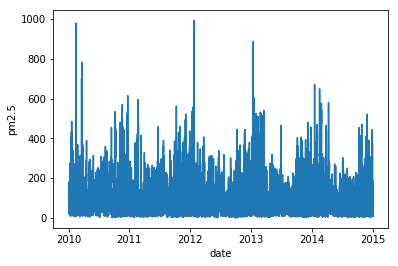

In [0]:
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

sns.lineplot(y="pm2.5", x="date", data=df)

For good results we need to do a bit of preprocessing. We will start by scaling the numerical variables so that they are between zero and one.

In [0]:
from sklearn import preprocessing

min_max_columns=["DEWP", "PRES", "TEMP", "pm2.5", "Iws", "Is", "Ir"]
min_max_scaler = preprocessing.MinMaxScaler()
df[ list(map(lambda x: x+"_scaled", min_max_columns)) ]=pd.DataFrame(min_max_scaler.fit_transform(df[min_max_columns].values))


The wind direction in the **cbwd**-variable can be one-hot encoded.

In [0]:
df=pd.concat([df, pd.get_dummies(df[["cbwd"]])], axis=1)

In [0]:
df.head(10)

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,date,DEWP_scaled,PRES_scaled,TEMP_scaled,pm2.5_scaled,Iws_scaled,Is_scaled,Ir_scaled,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv
date,,,,,,,,,,,,,,,,,,,,,,,,
0,2010,1,1,0,98.613215,-21,-11.0,1021.0,NW,1.79,0,0,2010-01-01 00:00:00,0.279412,0.545455,0.131148,0.099208,0.002290,0.0,0.0,0,1,0,0
1,2010,1,1,1,98.613215,-21,-12.0,1020.0,NW,4.92,0,0,2010-01-01 01:00:00,0.279412,0.527273,0.114754,0.099208,0.007639,0.0,0.0,0,1,0,0
2,2010,1,1,2,98.613215,-21,-11.0,1019.0,NW,6.71,0,0,2010-01-01 02:00:00,0.279412,0.509091,0.131148,0.099208,0.010698,0.0,0.0,0,1,0,0
3,2010,1,1,3,98.613215,-21,-14.0,1019.0,NW,9.84,0,0,2010-01-01 03:00:00,0.279412,0.509091,0.081967,0.099208,0.016047,0.0,0.0,0,1,0,0
4,2010,1,1,4,98.613215,-20,-12.0,1018.0,NW,12.97,0,0,2010-01-01 04:00:00,0.294118,0.490909,0.114754,0.099208,0.021396,0.0,0.0,0,1,0,0
5,2010,1,1,5,98.613215,-19,-10.0,1017.0,NW,16.10,0,0,2010-01-01 05:00:00,0.308824,0.472727,0.147541,0.099208,0.026745,0.0,0.0,0,1,0,0
6,2010,1,1,6,98.613215,-19,-9.0,1017.0,NW,19.23,0,0,2010-01-01 06:00:00,0.308824,0.472727,0.163934,0.099208,0.032094,0.0,0.0,0,1,0,0
7,2010,1,1,7,98.613215,-19,-9.0,1017.0,NW,21.02,0,0,2010-01-01 07:00:00,0.308824,0.472727,0.163934,0.099208,0.035153,0.0,0.0,0,1,0,0
8,2010,1,1,8,98.613215,-19,-9.0,1017.0,NW,24.15,0,0,2010-01-01 08:00:00,0.308824,0.472727,0.163934,0.099208,0.040502,0.0,0.0,0,1,0,0


In [0]:
lag_length=5
features=["DEWP_scaled", "TEMP_scaled", "Iws_scaled", "Is_scaled", "Ir_scaled", "month", "hour", "cbwd_NE", "cbwd_NW", "cbwd_SE", "cbwd_cv", "pm2.5_scaled"]


Prepare the data for training

In [0]:
import numpy as np

X=[]
y=[]
feature_cols=df[features].values
output_col=df["pm2.5_scaled"]
for i in range(lag_length, 20000):
  example=[]
  for lag in range(-lag_length,0):
    row=feature_cols[i+lag]
    example.append(row)
  X.append(example)
  y.append(output_col[i])
  
X=np.array(X)
y=np.array(y)

The shape of the training data is (number of observations, number lagged timesteps, number of features)

In [0]:
X.shape

(19995, 5, 12)

The output is a scalar

In [0]:
y.shape

(19995,)

We split the dataset, so that the first 50% of the dataset is the training data and the last 50% are test data.

In [0]:
training_examples=round(y.shape[0]/2)
X_train=X[:training_examples,]
X_test=X[training_examples:,]
y_train=y[:training_examples,]
y_test=y[training_examples:,]

For the actual model we will use one LSTM layer with 4 nodes 

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(4, input_shape=(lag_length, len(features))))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4)                 272       
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 277
Trainable params: 277
Non-trainable params: 0
_________________________________________________________________


We train the model for 80 epochs.

In [0]:
history = model.fit(X_train, y_train, epochs=80, batch_size=200, validation_data=(X_test, y_test), verbose=2, shuffle=False)

Train on 9998 samples, validate on 9997 samples
Epoch 1/80
9998/9998 - 4s - loss: 0.0913 - val_loss: 0.0760
Epoch 2/80
9998/9998 - 0s - loss: 0.0724 - val_loss: 0.0690
Epoch 3/80
9998/9998 - 0s - loss: 0.0675 - val_loss: 0.0666
Epoch 4/80
9998/9998 - 0s - loss: 0.0655 - val_loss: 0.0655
Epoch 5/80
9998/9998 - 0s - loss: 0.0644 - val_loss: 0.0648
Epoch 6/80
9998/9998 - 0s - loss: 0.0638 - val_loss: 0.0644
Epoch 7/80
9998/9998 - 0s - loss: 0.0633 - val_loss: 0.0641
Epoch 8/80
9998/9998 - 0s - loss: 0.0629 - val_loss: 0.0637
Epoch 9/80
9998/9998 - 0s - loss: 0.0626 - val_loss: 0.0634
Epoch 10/80
9998/9998 - 0s - loss: 0.0623 - val_loss: 0.0632
Epoch 11/80
9998/9998 - 0s - loss: 0.0620 - val_loss: 0.0628
Epoch 12/80
9998/9998 - 0s - loss: 0.0617 - val_loss: 0.0625
Epoch 13/80
9998/9998 - 0s - loss: 0.0614 - val_loss: 0.0621
Epoch 14/80
9998/9998 - 0s - loss: 0.0610 - val_loss: 0.0616
Epoch 15/80
9998/9998 - 0s - loss: 0.0606 - val_loss: 0.0611
Epoch 16/80
9998/9998 - 0s - loss: 0.0600 - va

We can plot the training and validation loss for each epoch

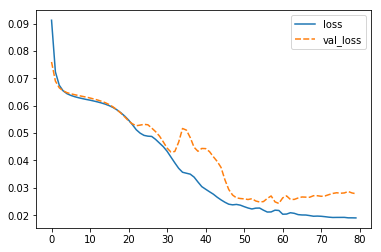

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)
training_performance = pd.DataFrame(data={"loss": loss, "val_loss": val_loss})

sns.lineplot(data=training_performance)

The size of the LSTM layer is 4. Is this a good size?
Try changing the size of the LSTM layer and compare

Normally we would shuffle the dataset before split train and test data. In this case we did not do this. Why not?